In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler

INFOLDER = "./logs_augm_no_augm/real_xgb_only/"

metrics  = [os.path.join(INFOLDER, x, "metrics.csv") for x in os.listdir(INFOLDER) if x.endswith("xgb_onehot")]
models = {x: os.path.join(INFOLDER, x, "model.pkl") for x in os.listdir(INFOLDER) if x.endswith("xgb_onehot")}

In [44]:
with open(os.path.join(INFOLDER, "test_cmd.txt")) as f:
    X_test_cmd = f.readlines()

mal = 9
ben = len(X_test_cmd) - mal
y_test = np.concatenate((np.zeros(ben), np.ones(mal)))
print(len(X_test_cmd))
y_test.shape

235237


(235237,)

In [27]:
print("Loading augmented data...")
oh_augm = pickle.load(open(os.path.join(INFOLDER, "augm_onehot_4096.pkl"), "rb"))
X_test_augm = oh_augm.transform(X_test_cmd)

print("Loading non augmented data...")
oh_non_augm = pickle.load(open(os.path.join(INFOLDER, "not_augm_onehot_4096.pkl"), "rb"))
X_test_non_augm = oh_non_augm.transform(X_test_cmd)

Loading augmented data...
Loading non augmented data...


Loading model augm_xgb_onehot
Predicting...
Loading model not_augm_xgb_onehot
Predicting...
Loading model not_augm_balanced_xgb_onehot
Predicting...


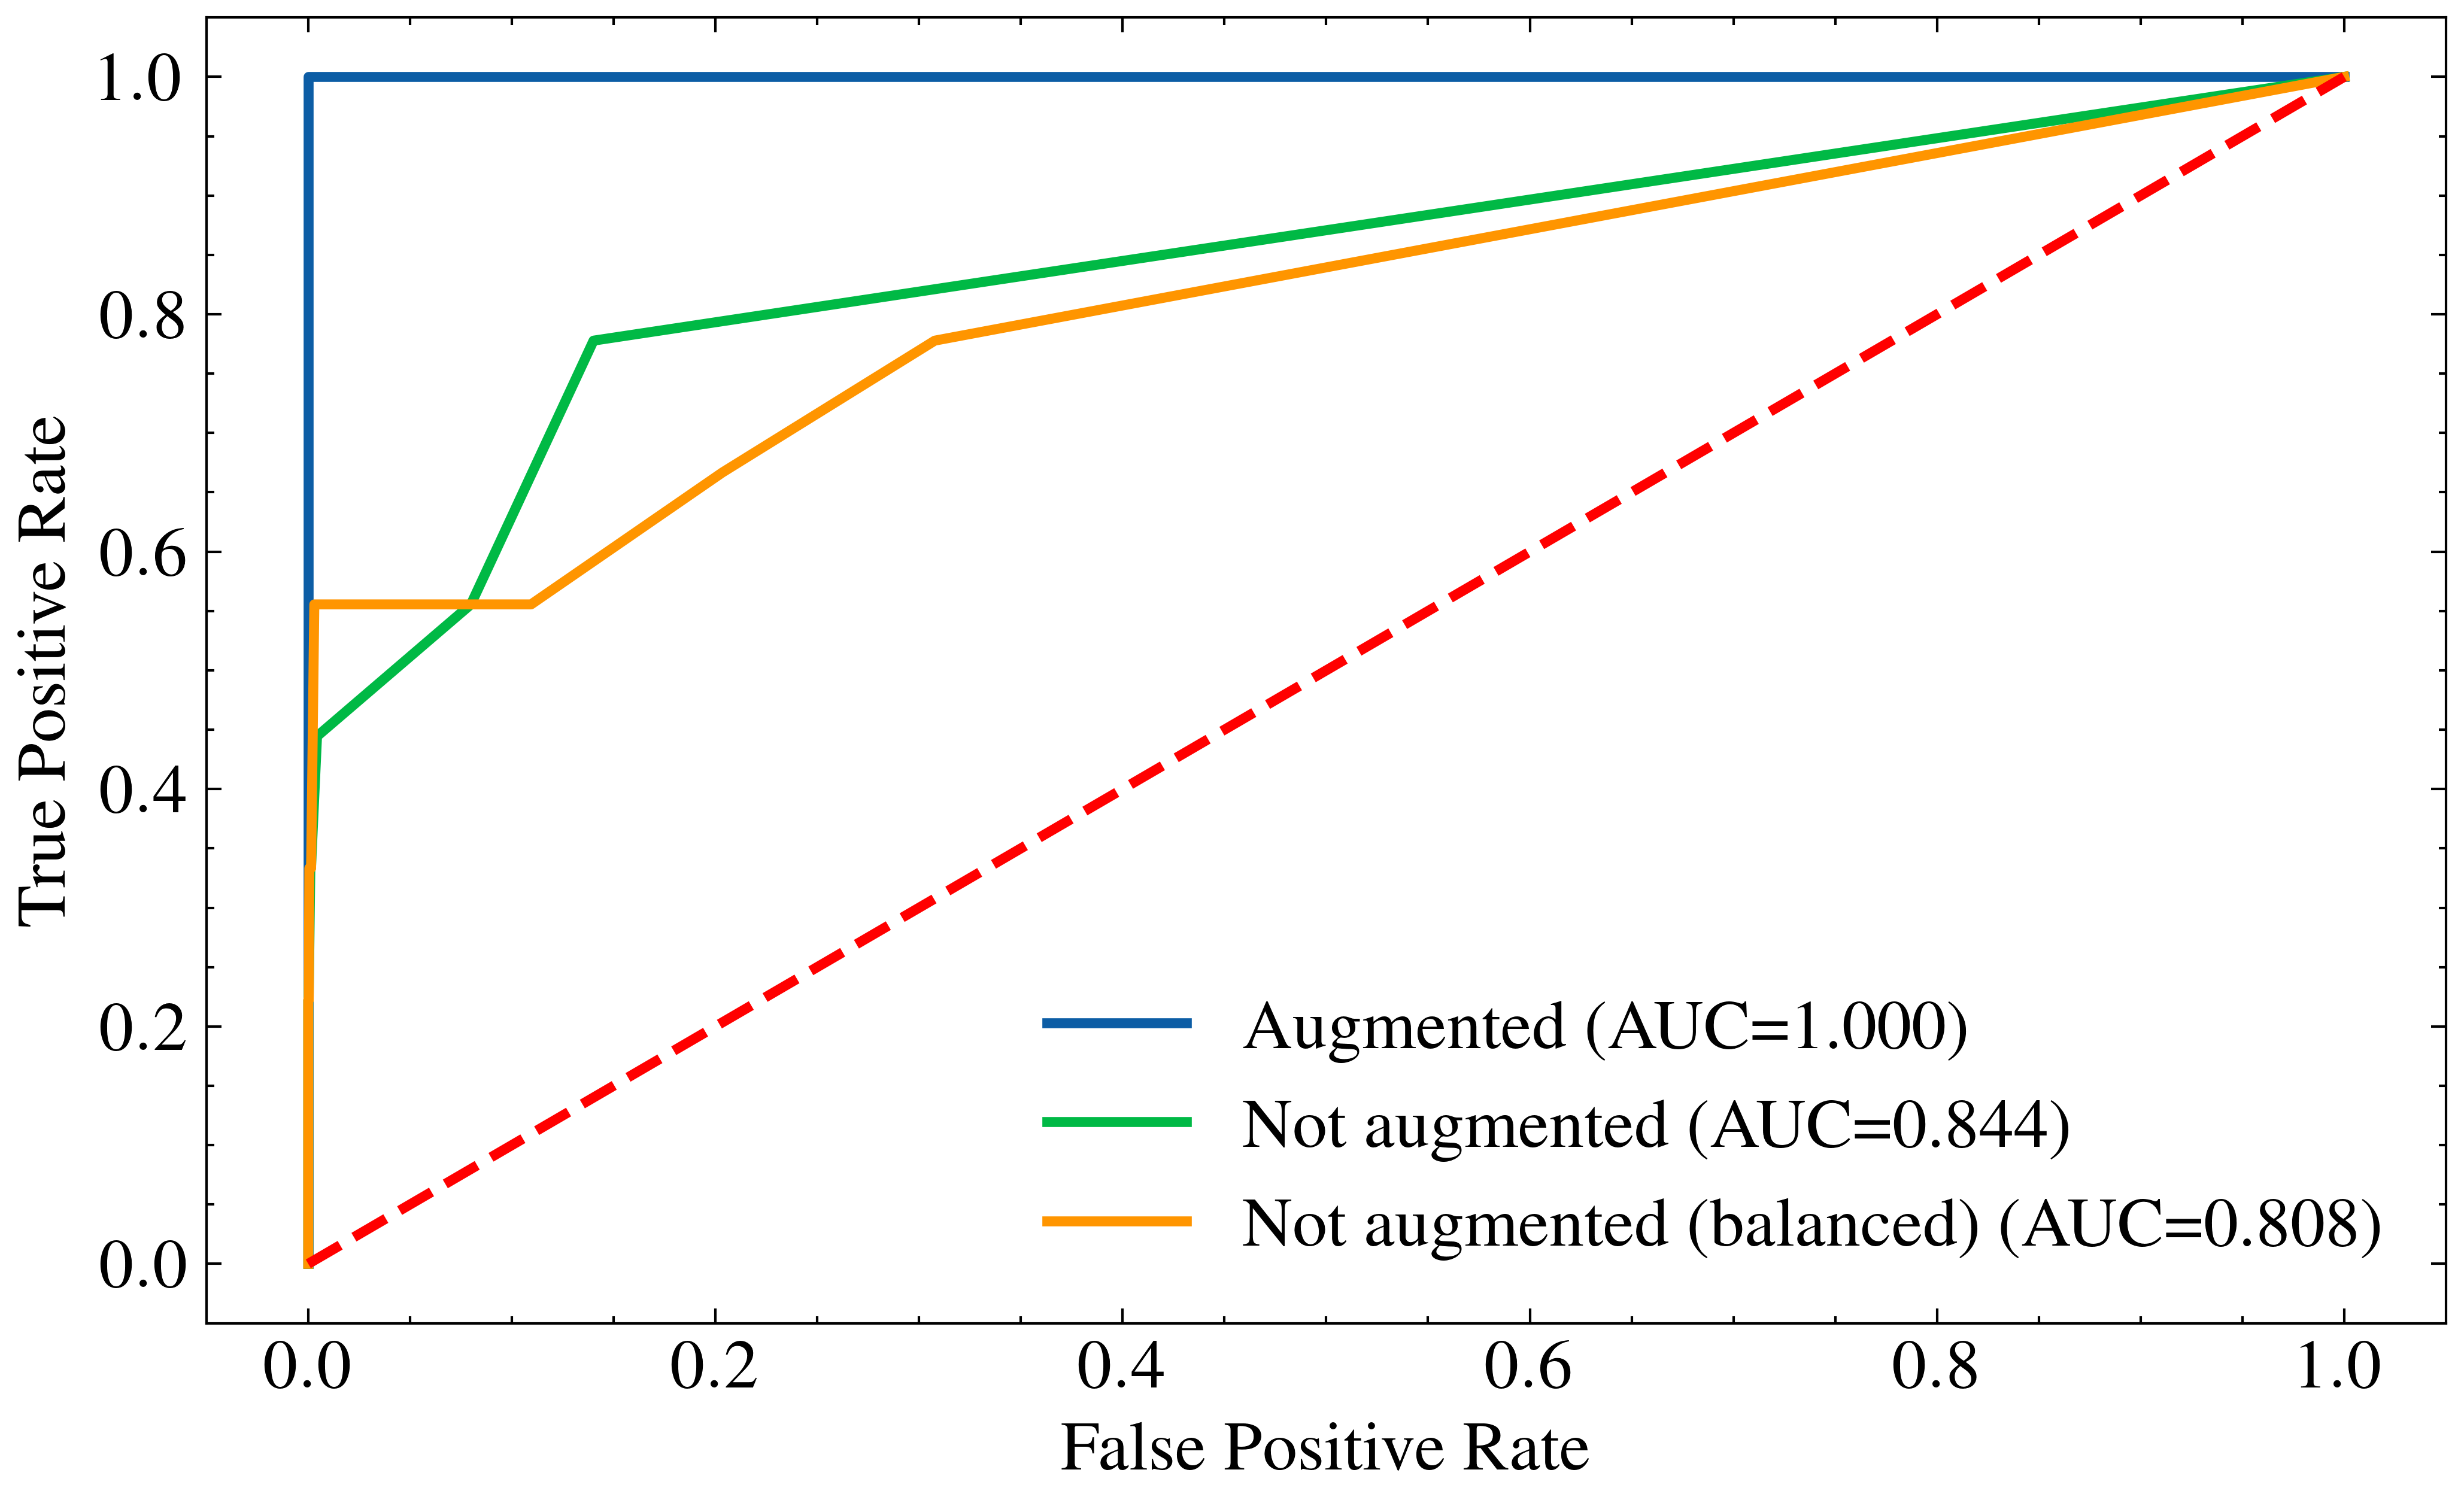

In [63]:
import scienceplots
plt.style.use(['science'])

from src.plots import set_size


labelmap = {
    'augm': "Augmented",
    'not_augm': "Not augmented",
    'not_augm_balanced': "Not augmented (balanced)",
}

fig, ax = plt.subplots(figsize=set_size())
for name, label in labelmap.items():
    key = name + "_xgb_onehot"
    model_path = models[key]
    print("Loading model {}".format(key))
    model = pickle.load(open(model_path, "rb"))


    print("Predicting...")
    if "not" in key:
        # shuffle data
        X, y = shuffle(X_test_non_augm, y_test, random_state=42)
        y_pred = model.predict_proba(X)[:, 1]
    else:
        # shuffle data
        X, y = shuffle(X_test_augm, y_test, random_state=42)
        y_pred = model.predict_proba(X)[:, 1]

    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    ax.plot(fpr, tpr, label="{} (AUC={:.3f})".format(label, auc), lw=2)

ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.tick_params(labelsize=14)

ax.legend(fontsize=14)
# ax.grid(lw=0.5)

plt.tight_layout()
plt.savefig(f"img/augm_non_augm.pdf", dpi=300)